<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/dataaug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Augmentation

In [2]:
# googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Deep_Learning/DL_Lecture2

/content/drive/MyDrive/Deep_Learning/DL_Lecture2


In [4]:
import numpy as np
from torchvision import transforms
from torch import optim
from torch.nn import functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### torchvision.transforms

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


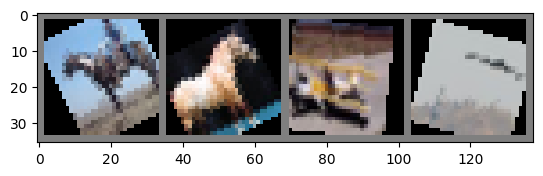

In [6]:
X, y = next(iter(train_loader))
X = make_grid(X).permute(1, 2, 0)
X = X / 2 + 0.5
plt.imshow(X)

### Albumentations

In [ ]:
!pip install albumentations
!pip install opencv-python

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [12]:
transform = A.Compose([
    A.HorizontalFlip(),
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.RandomCrop(height=32, width=32),
    A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ToTensorV2(),
])

In [13]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, target=None):
        image = self.transform(image=np.array(image))['image']
        if target:
            return image, target
        else:
            return image

In [14]:
transform = AlbumentationsTransform(transform)

In [15]:
train_dataset = CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


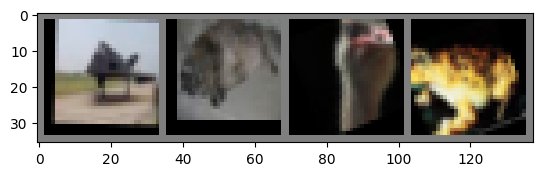

In [16]:
X, y = next(iter(train_loader))
X = make_grid(X).permute(1, 2, 0)
X = X / 2 + 0.5
plt.imshow(X)

### imgaug

In [ ]:
!pip install imgaug

In [18]:
from imgaug import augmenters as iaa
import imgaug as ia

In [19]:
transform_ia_seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Pad(px=4),
    iaa.CropToFixedSize(width=32, height=32),
    iaa.Affine(rotate=(-30, 30))
])

class ImgAugTransform:
    def __init__(self, ia_seq):
        self.ia_seq = ia_seq

    def __call__(self, image, target=None):
        image = self.ia_seq.augment_image(np.array(image))
        if target:
            return image, target
        else:
            return image

Files already downloaded and verified


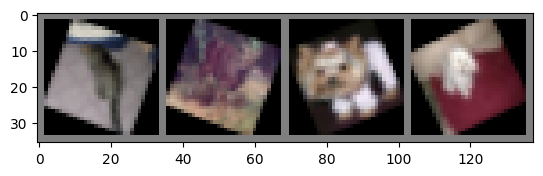

In [20]:
transform_ia = ImgAugTransform(transform_ia_seq)
transform = transforms.Compose([
    transform_ia,
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
X, y = next(iter(train_loader))
X = make_grid(X).permute(1, 2, 0)
X = X / 2 + 0.5
plt.imshow(X)

## Data augmentationで学習

In [21]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
val_dataset = CIFAR10('./cifar10_data', train=False, download=True, transform=transform_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
conv_model = utils.get_conv_model(in_ch=3)
opt = optim.Adam(conv_model.parameters(), lr=0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 10)

epoch: 0: train error: 1.7675053683083382, validation error: 1.5877545589133153, validation accuracy: 0.4219738924050633


epoch: 1: train error: 1.5948810534708946, validation error: 1.5057222873349734, validation accuracy: 0.4467958860759494


epoch: 2: train error: 1.5422944400621497, validation error: 1.4360339913187148, validation accuracy: 0.4742879746835443


epoch: 3: train error: 1.5182867662985917, validation error: 1.417557345160955, validation accuracy: 0.4787381329113924


epoch: 4: train error: 1.4910466448425332, validation error: 1.3507335638698144, validation accuracy: 0.5060324367088608


epoch: 5: train error: 1.4784680217733164, validation error: 1.4465204326412346, validation accuracy: 0.47310126582278483


epoch: 6: train error: 1.4687515390498558, validation error: 1.3407567015177086, validation accuracy: 0.510878164556962


epoch: 7: train error: 1.453579972162271, validation error: 1.3277128829231746, validation accuracy: 0.5135482594936709


epoch: 8: train error: 1.446475001857104, validation error: 1.4108955347085301, validation accuracy: 0.48823180379746833


epoch: 9: train error: 1.4456422911275684, validation error: 1.3566775518127634, validation accuracy: 0.5117681962025317


In [24]:
train_dataset_no_aug = CIFAR10('./cifar10_data', train=True, download=True, transform=transform_val)
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=128, shuffle=True, num_workers=4)
conv_model_no_aug = utils.get_conv_model(in_ch=3)
opt_no_aug = optim.Adam(conv_model_no_aug.parameters(), lr=0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_no_aug, train_loader_no_aug, val_loader, opt_no_aug, F.cross_entropy, 10)

Files already downloaded and verified


epoch: 0: train error: 1.6045268975255433, validation error: 1.4341335115553457, validation accuracy: 0.4844738924050633


epoch: 1: train error: 1.4003837038488949, validation error: 1.3900404942186573, validation accuracy: 0.49238528481012656


epoch: 2: train error: 1.3260267829651113, validation error: 1.3240209983873972, validation accuracy: 0.5155261075949367


epoch: 3: train error: 1.2753967299790638, validation error: 1.3398371361478973, validation accuracy: 0.5206685126582279


epoch: 4: train error: 1.2453838272777664, validation error: 1.2639546439617495, validation accuracy: 0.546182753164557


epoch: 5: train error: 1.2186695585775253, validation error: 1.2344336313537405, validation accuracy: 0.5568631329113924


epoch: 6: train error: 1.2023007150196359, validation error: 1.255384541765044, validation accuracy: 0.5494462025316456


epoch: 7: train error: 1.1847451038067909, validation error: 1.231000980244407, validation accuracy: 0.5657634493670886


epoch: 8: train error: 1.1683734170616131, validation error: 1.2513167511058758, validation accuracy: 0.5520174050632911


epoch: 9: train error: 1.1582882712259317, validation error: 1.2133777911150003, validation accuracy: 0.5644778481012658
